In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from tqdm import tqdm
import torchdata.datapipes as dp
import torchtext.transforms as T
from torchtext.vocab import build_vocab_from_iterator
import spacy
import random

### Getting The Data

In [2]:
def get_data(folder_path, file1_name, file2_name):
    # Initialize an empty dictionary
    data = []

    # Read the contents of both files and populate the dictionary
    with open(f"{folder_path}/{file1_name}", 'r') as file1, open(f"{folder_path}/{file2_name}", 'r') as file2:
        lines_file1 = file1.readlines()
        lines_file2 = file2.readlines()

        # Assuming both files have the same number of lines
        for line1, line2 in zip(lines_file1, lines_file2):
            if line1.strip() != '' and line2.strip() != '':
                sentence1 = line1.strip()
                sentence2 = line2.strip()
                data.append((sentence1, sentence2))

    return data

In [3]:
train_data = get_data('translation_dataset/training', 'train.de', 'train.en')
val_data = get_data('translation_dataset/validation/', 'val.de', 'val.en')
test_data = get_data('translation_dataset/testing/', 'test.de', 'test.en')

### Preprocessing The Data into Datapipes

In [4]:
train_data = dp.iter.IterableWrapper(train_data)
val_data = dp.iter.IterableWrapper(val_data)
test_data = dp.iter.IterableWrapper(test_data)

In [5]:
# Remove This Line
train_data = test_data

In [6]:
list(test_data)[-1]

('Ein Mädchen an einer Küste mit einem Berg im Hintergrund.',
 'A girl at the shore of a beach with a mountain in the distance.')

In [7]:
spacy_de = spacy.load('/Users/arunreddy/opt/anaconda3/envs/NLP_PYTORCH/lib/python3.8/site-packages/spacy/data/de')
spacy_en = spacy.load('/Users/arunreddy/opt/anaconda3/envs/NLP_PYTORCH/lib/python3.8/site-packages/spacy/data/en')

In [8]:
def eng_tokenizer(text):
    return [tok.text for tok in spacy_en(text)]

def de_tokenizer(text):
    return [tok.text for tok in spacy_de(text)]

In [9]:
def getTokens(data_iter, place):
    for german, english in data_iter:
        if place == 0:
            yield de_tokenizer(german)
        else:
            yield eng_tokenizer(english)

### Building the vocabulary

In [10]:
vocab_de = build_vocab_from_iterator(getTokens(train_data,0), min_freq=2, specials=["<sos>", "<eos>", "<unk>", "<pad>"], special_first=True)
vocab_en = build_vocab_from_iterator(getTokens(train_data,1), min_freq=2, specials=["<sos>", "<eos>", "<unk>", "<pad>"], special_first=True)
vocab_de.set_default_index(vocab_de["<unk>"])
vocab_en.set_default_index(vocab_en["<unk>"])

In [11]:
print(vocab_de.get_itos()[:10])

['<sos>', '<eos>', '<unk>', '<pad>', '.', 'einem', 'Ein', 'in', 'auf', 'und']


In [12]:
print(vocab_en.get_itos()[:10])

['<sos>', '<eos>', '<unk>', '<pad>', 'a', '.', 'A', 'in', 'the', 'on']


### Numericalize sentences using the vocabulary

In [13]:
def getTransform(vocab, sentence):
    sentence_transform = T.Sequential(
        T.VocabTransform(vocab=vocab),
        T.AddToken(0, begin=True),
        T.AddToken(1, begin=False)
    )
    if (vocab==vocab_de):
        tokenized_text =[tok.text for tok in spacy_de(sentence)]
    else:
        tokenized_text =[tok.text for tok in spacy_en(sentence)]
    return sentence_transform(tokenized_text)

In [14]:
def getInvTransform(vocab, sentence):
    result = ""
    for i in sentence:
        result += vocab.get_itos()[i] + " "
    return result

In [15]:
sentence_de = list(train_data)[10][0]
sentence_en = list(train_data)[10][1]

In [16]:
sentence_de, sentence_en

('Eine Mutter und ihr kleiner Sohn genießen einen schönen Tag im Freien.',
 'A mother and her young song enjoying a beautiful day outside.')

In [17]:
getTransform(vocab_de, sentence_de)

[0, 14, 575, 9, 338, 87, 2, 694, 18, 348, 179, 17, 57, 4, 1]

In [18]:
getTransform(vocab_en, sentence_en)

[0, 6, 705, 10, 55, 26, 529, 302, 4, 359, 155, 49, 5, 1]

In [20]:
def ApplyTransform(sequence_pair):

    return (getTransform(vocab_de, sequence_pair[0]), getTransform(vocab_en, sequence_pair[1]))

In [21]:
train_data_transformed = train_data.map(ApplyTransform)

### Making Batches.

In [22]:
for sample in train_data:
    print(sample)
    break

('Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.', 'A man in an orange hat starring at something.')


In [23]:
for sample in train_data_transformed:
    print(sample)
    break

([0, 6, 11, 10, 5, 151, 225, 13, 20, 115, 2, 4, 1], [0, 6, 12, 7, 28, 94, 86, 2, 19, 134, 5, 1])


In [24]:
def sortBucket(bucket):
    """
    Function to sort a given bucket. Here, we want to sort based on the length of
    source and target sequence.
    """
    return sorted(bucket, key=lambda x: (len(x[0]), len(x[1])))

In [25]:
train_data_transformed = train_data_transformed.bucketbatch(
    batch_size = 4, batch_num=5,  bucket_num=1,
    use_in_batch_shuffle=False, sort_key=sortBucket
)

In [26]:
for sample in train_data_transformed:
    print(sample)
    break

[([0, 6, 44, 2, 17, 73, 4, 1], [0, 6, 47, 11, 530, 7, 8, 52, 1]), ([0, 6, 11, 347, 2, 25, 173, 4, 1], [0, 6, 12, 625, 2, 14, 212, 5, 1]), ([0, 58, 13, 22, 27, 5, 94, 49, 4, 1], [0, 58, 34, 49, 14, 4, 76, 5, 1]), ([0, 14, 2, 16, 36, 8, 5, 2, 4, 1], [0, 6, 2, 16, 108, 4, 2, 5, 1])]


In [29]:
# Generally, while training a model,
# we predict on a batch of X and compare the result with y. 
# But, a batch in our data_pipe is of the form [(X_1,y_1), (X_2,y_2), (X_3,y_3), (X_4,y_4)]:
# So, we will now convert them into the form: ((X_1,X_2,X_3,X_4), (y_1,y_2,y_3,y_4)). For this we will write a small function:

In [30]:
def separateSourceTarget(sequence_pairs):
    """
    input of form: `[(X_1,y_1), (X_2,y_2), (X_3,y_3), (X_4,y_4)]`
    output of form: `((X_1,X_2,X_3,X_4), (y_1,y_2,y_3,y_4))`
    """
    sources,targets = zip(*sequence_pairs)
    return sources,targets

In [31]:
train_data_transformed = train_data_transformed.map(separateSourceTarget)

In [32]:
for batch in train_data_transformed:
    for sample in batch:
        print(sample) 
        print("\n")
    break

([0, 93, 91, 140, 118, 8, 22, 2, 4, 1], [0, 315, 58, 106, 2, 70, 21, 2, 4, 1], [0, 254, 80, 49, 7, 242, 2, 8, 5, 583, 4, 1], [0, 6, 11, 40, 61, 2, 2, 7, 12, 256, 4, 1])


([0, 45, 26, 122, 11, 48, 19, 8, 2, 5, 1], [0, 347, 24, 207, 107, 436, 67, 4, 2, 2, 5, 1], [0, 291, 113, 15, 34, 9, 4, 730, 7, 99, 2, 534, 5, 1], [0, 6, 12, 11, 34, 46, 4, 43, 14, 551, 2, 7, 4, 217, 5, 1])




### Making Padding

In [33]:
def applyPadding(pair_of_sequences):
    """
    Convert sequences to tensors and apply padding
    """
    return (T.ToTensor(3)(list(pair_of_sequences[0])), T.ToTensor(3)(list(pair_of_sequences[1])))

In [34]:
train_data_transformed = train_data_transformed.map(applyPadding)

### Displaying The Final Processed Data Form

In [35]:
for sources, targets in train_data_transformed:
    print(sources.shape)
    print(targets.shape)
    break

torch.Size([4, 13])
torch.Size([4, 14])


In [36]:
# Keep this in mind the loop variables in python can leak out.

In [37]:
for sources, targets in train_data_transformed:
    batch_size = sources.shape[0]
    for i in range(batch_size):
        source = sources[i]
        target = targets[i]
        source_sentence = getInvTransform(vocab_de, source.numpy())
        target_sentence = getInvTransform(vocab_en, target.numpy())
        print(f"The source sample {i} is ", source_sentence)
        print(f"The target sample {i} is ", target_sentence)
        print("-----------------------------------------")
    break

The source sample 0 is  <sos> Eine Frau in einem pinken Pulli und einer Schürze <unk> einen Tisch mit einem <unk> . <eos> <pad> <pad> <pad> 
The target sample 0 is  <sos> A woman in a pink sweater and an apron , <unk> a table with a <unk> . <eos> <pad> <pad> <pad> <pad> 
-----------------------------------------
The source sample 1 is  <sos> Ein Mann drückt den Kopf eines anderen Mannes nach unten und <unk> ihm ins Gesicht <unk> . <eos> <pad> <pad> 
The target sample 1 is  <sos> One man holds another man 's head down and prepares to <unk> him in the face . <eos> <pad> <pad> <pad> <pad> 
-----------------------------------------
The source sample 2 is  <sos> Drei Leute sitzen an einem Picknicktisch vor einem Gebäude , das wie der <unk> <unk> <unk> ist . <eos> <pad> 
The target sample 2 is  <sos> Three people sit at a picnic table outside of a building painted like a <unk> <unk> . <eos> <pad> <pad> <pad> <pad> 
-----------------------------------------
The source sample 3 is  <sos> Ein A

### Finally Data Preprocessing is Done.

In [38]:
class Encoder(nn.Module):
    def __init__ (self, enc_vocab_size, enc_embedding_size, enc_hid_dim,dec_hid_dim, enc_n_layers, dec_n_layers, enc_drop):
        super(Encoder, self).__init__()

        self.embedding = nn.Embedding(enc_vocab_size, enc_embedding_size)
        self.rnn = nn.LSTM(enc_embedding_size, enc_hid_dim, enc_n_layers, batch_first=True, bidirectional=True)
        self.fc_hidden = nn.Linear(enc_hid_dim*2, dec_hid_dim)
        self.fc_cell = nn.Linear(enc_hid_dim*2, dec_hid_dim)
        self.dec_n_layers = dec_n_layers
        self.dropout = nn.Dropout(enc_drop)
        self.relu = nn.ReLU()

    def forward(self, x):
        # x->(N, L)
        embedded = self.dropout(self.embedding(x))

        # embedded-> (N, L, H_enc_em)

        output, (hidden, cell) = self.rnn(embedded)

        # output->(N, L, 2*enc_hid_dim)
        # hidden, cell->(2*enc_n_layers,N,enc_hid_dim)

        context_hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)

        context_cell = torch.cat((cell[-2,:,:], cell[-1,:,:]), dim=1)

        # context_hidden->(N, enc_hid_dim*2)
        # context_cell->(N, enc_hid_dim*2)

        init_dec_hidden = self.relu(self.fc_hidden(context_hidden)).unsqueeze(0).repeat(self.dec_n_layers, 1,1)

        init_dec_cell = self.relu(self.fc_cell(context_cell)).unsqueeze(0).repeat(self.dec_n_layers, 1, 1)

        # init_dec_hidden, init_dec_cell->(dec_n_layers, N, dec_hid_dim)

        return output, init_dec_hidden, init_dec_cell

In [39]:
encoder = Encoder(13, 18, 128, 128,5, 5,0.1)
inputs = torch.randint(0,13, (10, 12))
output, init_dec_hidden, init_dec_cell = encoder(inputs)
output.shape, init_dec_hidden.shape, init_dec_cell.shape

(torch.Size([10, 12, 256]), torch.Size([5, 10, 128]), torch.Size([5, 10, 128]))

In [40]:
class BahdanauAttention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super(BahdanauAttention, self).__init__()
        self.W = nn.Linear(2*enc_hid_dim+dec_hid_dim+dec_hid_dim, dec_hid_dim, bias=False)
        self.v = nn.Linear(dec_hid_dim, 1, bias=False)

    def forward(self, enc_hidden_states, prev_dec_hidden_state, prev_dec_cell_state):
        
        # enc_hidden_states -> (N, L, 2*enc_hid_dim)
        # prev_dec_hidden_state -> (dec_n_layers, N, dec_hid_dim)
        # prev_dec_cell_state -> (dec_n_layers, N, dec_hid_dim)

        seq_length = enc_hidden_states.shape[1]
        prev_dec_hidden_context = prev_dec_hidden_state[-1].unsqueeze(1).repeat(1, seq_length, 1)
        prev_dec_cell_context = prev_dec_cell_state[-1].unsqueeze(1).repeat(1, seq_length, 1)

        # prev_dec_hidden_context -> (N, L, dec_hid_dim)
        # prev_dec_cell_context -> (N, L, dec_hid_dim)

        combined_state = torch.cat((enc_hidden_states, prev_dec_hidden_context, prev_dec_cell_context), dim=2)

        # combined_state -> (N, L, 2*enc_hid_dim + dec_hid_dim + dec_hid_dim)

        un_norm_attn_scores = self.v(self.W(combined_state))

        # un_norm_attn_scores -> (N, L, 1)

        return F.softmax(un_norm_attn_scores.squeeze(2), dim=1) # -> (N, L)

In [41]:
attn = BahdanauAttention(128, 128)
enc_hidden_states = torch.randn(10, 12, 2*128)
prev_dec_hidden_state = torch.randn(5, 10, 128)
prev_dec_cell_state = torch.randn(5, 10, 128)
scores = attn(enc_hidden_states, prev_dec_hidden_state, prev_dec_cell_state)

In [42]:
scores.shape

torch.Size([10, 12])

In [43]:
class Decoder(nn.Module):
    def __init__(self, output_dim, dec_hid_dim, dec_n_layers, enc_hid_dim, input_dim, dec_embedding_size, dec_drop, attention):
        super(Decoder, self).__init__()

        self.attention = attention
        self.dropout = nn.Dropout(dec_drop)
        self.output_dim = output_dim

        self.embedding = nn.Embedding(input_dim, dec_embedding_size)
        self.rnn = nn.LSTM(2*enc_hid_dim+dec_embedding_size, dec_hid_dim, dec_n_layers,batch_first=True)
        self.fc_out = nn.Linear(2*enc_hid_dim+dec_embedding_size+dec_hid_dim, output_dim)

    def forward (self, input, prev_dec_hidden_state, prev_dec_cell_state, enc_hidden_states):

        # input -> (N, 1)
        # prev_dec_hidden_state = prev_dec_cell_state -> (dec_n_layers, N, dec_hid_dim)
        # enc_hidden_states -> (N, L, 2*enc_hid_dim)

        embedded = self.dropout(self.embedding(input))
        # embedded->(N, 1, dec_embedding_size)
        
        # calculating the context vector.
        attn_scores = self.attention(enc_hidden_states, prev_dec_hidden_state, prev_dec_cell_state)

        # attn_scores->(N, L)
        context_vector = torch.bmm(attn_scores.unsqueeze(1), enc_hidden_states)

        # context_vector-> (N, 1, 2*enc_hid_dim)

        rnn_input = torch.cat((embedded, context_vector), dim=2)
        # rnn_input->(N, 1, 2*enc_hid_dim+dec_embedding_size)

        output, (hidden, cell) = self.rnn(rnn_input, (prev_dec_hidden_state, prev_dec_cell_state))

        # output->(N, 1, dec_hid_dim)
        # hidden = cell->(dec_n_layers, N, dec_hid_dim)


        prediction = self.fc_out(torch.cat((embedded, context_vector, output), dim=2).squeeze(1))
        # prediction->(N, output_dim)

        return prediction, (hidden, cell)

In [44]:
256+18

274

In [45]:
decoder = Decoder(200, 128, 5, 128, 200, 18, 0.2, attn)
input = torch.randint(0, 200, (10,1))
prediction, (hidden, cell) = decoder(input, prev_dec_hidden_state, prev_dec_cell_state, enc_hidden_states)

In [46]:
prediction.shape, hidden.shape, cell.shape

(torch.Size([10, 200]), torch.Size([5, 10, 128]), torch.Size([5, 10, 128]))

In [47]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()

        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg, teacher_force_ratio):

        # src->(N, L)
        # trg->(N, L')

        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        dec_outputs = torch.zeros(trg_len, batch_size, self.decoder.output_dim)
        output, init_dec_hidden, init_dec_cell = self.encoder(src)

        input = trg[:, 0]

        for t in range(1, trg_len):
            prediction, (hidden, cell) = self.decoder(input.unsqueeze(1), init_dec_hidden, init_dec_cell, output)
            # prediction->(N->output_dim)
            # hidden = cell -> (dec_n_layers, N, dec_hid_dim)
            dec_outputs[t] = prediction
            teacher_force = random.random() < teacher_force_ratio
            top1 = prediction.argmax(1)
            input = trg[:, t] if teacher_force else top1

        return dec_outputs.permute(1,0,2) #-> (N, L, output_dim)

In [48]:
s2s = Seq2Seq(encoder, decoder)
dec_outputs = s2s(torch.randint(0,5,(10,14)), torch.randint(0,5,(10,25)), 0.5)

In [49]:
dec_outputs.shape

torch.Size([10, 25, 200])

In [50]:
enc_vocab_size = len(vocab_de.get_itos())
enc_embedding_size = 25
enc_hid_dim = 25
dec_hid_dim = 25
enc_n_layers = 1
dec_n_layers = 1
enc_drop = 0.5
output_dim = len(vocab_en.get_itos())
input_dim = len(vocab_en.get_itos())
dec_embedding_size = 25
dec_drop = 0.5
dec_n_layers = 1
actual_encoder = Encoder(enc_vocab_size, enc_embedding_size, enc_hid_dim, dec_hid_dim, enc_n_layers, dec_n_layers, enc_drop)
actual_attn = BahdanauAttention(enc_hid_dim, dec_hid_dim)
actual_decoder = Decoder(output_dim, dec_hid_dim, dec_n_layers, enc_hid_dim, input_dim, dec_embedding_size, dec_drop, actual_attn)
actual_s2s = Seq2Seq(actual_encoder, actual_decoder)

In [51]:
optimizer = optim.Adam(actual_s2s.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=vocab_en.get_stoi()["<pad>"])

In [52]:
def train(model, iterator, optimizer, criterion):
    model.train()

    epoch_loss = 0

    for i, batch in tqdm(enumerate(iterator)):
        
        optimizer.zero_grad()
        source = batch[0] # -> (N, L)
        target = batch[1] # -> (N, L')

        predictions = model(source, target, 0.5) #-> (N, L', output_dim)
        
        target = target[:, 1:].reshape(-1) # -> (N, L'-1) -> (N*(L'-1))
        predictions = predictions[:,1:,:].reshape(-1, output_dim) #-> (N, L', output_dim) -> (N*(L'-1), output_dim)

        loss = criterion(predictions, target)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()

    print(epoch_loss/i)

In [53]:
for i in range(10):
    train(actual_s2s, train_data_transformed, optimizer, criterion)

250it [00:16, 15.00it/s]


5.2009725781329665


250it [00:15, 15.81it/s]


4.603021787352351


250it [00:16, 15.36it/s]


4.4815530566326585


250it [00:16, 14.90it/s]


4.374613053348648


250it [00:17, 14.56it/s]


4.293427253822725


250it [00:17, 14.52it/s]


4.220458491260268


250it [00:17, 14.37it/s]


4.162144240605304


250it [00:17, 14.24it/s]


4.105428957077394


250it [00:17, 14.20it/s]


4.055018787881935


250it [00:17, 14.06it/s]

3.9810871321513472


In [54]:
list = [5.2009725781329665, 4.603021787352351, 4.4815530566326585, 4.374613053348648, 4.293427253822725, 4.220458491260268
, 4.162144240605304
, 4.105428957077394
, 4.055018787881935
, 3.9810871321513472]

In [55]:
import matplotlib.pyplot as ply

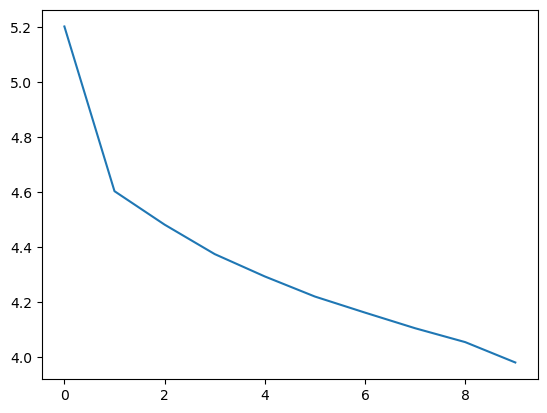

In [56]:
ply.plot(list)